# Test of Magnetic Model Evaluation - MCO_SHA_2C

In [1]:
from time import time as get_time

class Timer():
    def __init__(self):
        self.start = get_time()
 
    def __call__(self, label="elapsed time", restart=False):
        print("%s %gs" % (label, get_time() - self.start))
        if restart:
            self.start = get_time()

### Load model

In [2]:
import sys
from os.path import basename
MODEL_FILE = "./MCO_SHA_2x/SW_OPER_MCO_SHA_2C_20131201T000000_20180101T000000_0401.shc"

print(basename(MODEL_FILE))

with open(MODEL_FILE) as fin:
    for idx, line in enumerate(fin, 1):
        if idx > 5:
            print("...")
            break
        sys.stdout.write(line)

SW_OPER_MCO_SHA_2C_20131201T000000_20180101T000000_0401.shc
# Core field model derived using CI  
# Extracted from UMEQ file umeq.final
# created on 24-Jan-2018 10:57:47    
  1  16  41   5   4
          2013.9140   2014.0161   2014.1183   2014.2204   2014.3226   2014.4247   2014.5269   2014.6290   2014.7312   2014.8333   2014.9355   2015.0376   2015.1398   2015.2419   2015.3441   2015.4462   2015.5484   2015.6505   2015.7527   2015.8548   2015.9570   2016.0591   2016.1613   2016.2634   2016.3656   2016.4677   2016.5699   2016.6720   2016.7742   2016.8763   2016.9785   2017.0806   2017.1828   2017.2849   2017.3871   2017.4892   2017.5914   2017.6935   2017.7957   2017.8978   2018.0000
...


In [3]:
# generate random points
from math import pi
from numpy import sin, cos, dstack, linspace
from numpy.random import random, uniform

EARTH_RADIUS = 6371.2 # km
N_coords = 500

X = random((N_coords*2, 2))
X = X[X[..., 1] < sin(X[..., 0]*pi)][:N_coords, ...]
X[..., 0] = pi * (X[..., 0] - 0.5)
X[..., 1] = pi*(2.0*X[..., 1] / cos(X[..., 0]) - 1.0)
X *= 180./pi
lats = X[..., 0]
lons = X[..., 1]
rads = uniform(EARTH_RADIUS, 1.1*EARTH_RADIUS, N_coords)

coords = dstack((lats, lons, rads))[0]

In [4]:
# times
from numpy import linspace
from eoxmagmod import load_model_shc

model = load_model_shc(MODEL_FILE)
start, end = model.validity

N_times = 1500

times = linspace(start, end, N_times)

/home/pacesm/conda/lib/python3.7/site-packages/spacepy/pycdf/__init__.py:1209: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  class CDF(collections.MutableMapping):


### default version
- interpolated in the MJD2000 time domain
- decimal years aligned with callendar years

In [5]:
from numpy import empty
from eoxmagmod import load_model_shc

model_mjd2k = load_model_shc(MODEL_FILE)
print(model_mjd2k.coefficients)


timer = Timer()

b_nec_mjd2k = empty((N_times, N_coords, 3))
for idx, time in enumerate(times):
    b_nec_mjd2k[idx, ...] = model_mjd2k.eval(time, coords, scale=[1, 1, -1])

timer("model evaluated in")

model evaluated in 1.03891s


### decimal year interpolation
- intrepolated in the decimal year time domain
- decimal years aligned with callendar years

In [6]:
from numpy import empty
from eoxmagmod import load_model_shc

model_dy = load_model_shc(
    MODEL_FILE, interpolate_in_decimal_years=True
)
print(model_dy.coefficients)

timer = Timer()

b_nec_dy = empty((N_times, N_coords, 3))
for idx, time in enumerate(times):
    b_nec_dy[idx, ...] = model_dy.eval(time, coords, scale=[1, 1, -1])

timer("model evaluated in")

model evaluated in 1.04561s


### simplified MJD2000 calculation
- intrepolated in the MJD2000 time domain
- decimal years calculated using 365.25 days per year

In [7]:
from numpy import empty
from eoxmagmod import load_model_shc
from eoxmagmod.time_util import decimal_year_to_mjd2000_simple

model_mjd2k_simple = load_model_shc(
    MODEL_FILE, to_mjd2000=decimal_year_to_mjd2000_simple,
)
print(model_mjd2k_simple.coefficients)

timer = Timer()

b_nec_mjd2k_simple = empty((N_times, N_coords, 3))
for idx, time in enumerate(times):
    b_nec_mjd2k_simple[idx, ...] = model_mjd2k_simple.eval(time, coords, scale=[1, 1, -1])

timer("model evaluated in")

model evaluated in 1.04494s


## Plotting the results

In [8]:
from numpy import zeros, concatenate, isnan
from matplotlib import pyplot as plt
from eoxmagmod import vnorm
from eoxmagmod.time_util import mjd2000_to_decimal_year_simple as mjd2000_to_decimal_year


def plot(ax, x0, y0, label):
    x, y = [], []
    for idx in range(0, N_coords):
        x.append(x0)
        y.append(y0[:, idx])
    x, y = concatenate(x), concatenate(y)
    plt.plot(x, y, '.', markersize=2, color='#1f77b4', label='random samples')
    plt.plot(node_times, node_val, '+r', markersize=5, label='interpolation nodes')
    plt.ylabel(label)
    plt.legend(loc='upper right')
    plt.text(
        0.01, 0.95, 'max: %g nT' % y[~isnan(y)].max(),
        horizontalalignment='left', verticalalignment='top', transform=ax.transAxes
    )
    plt.text(
        0.01, 0.05, 'min: %g nT' % y[~isnan(y)].min(),
        horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes
    )
    plt.grid()

### Effect of the MJD2k vs. decimal_year interpolation time domain

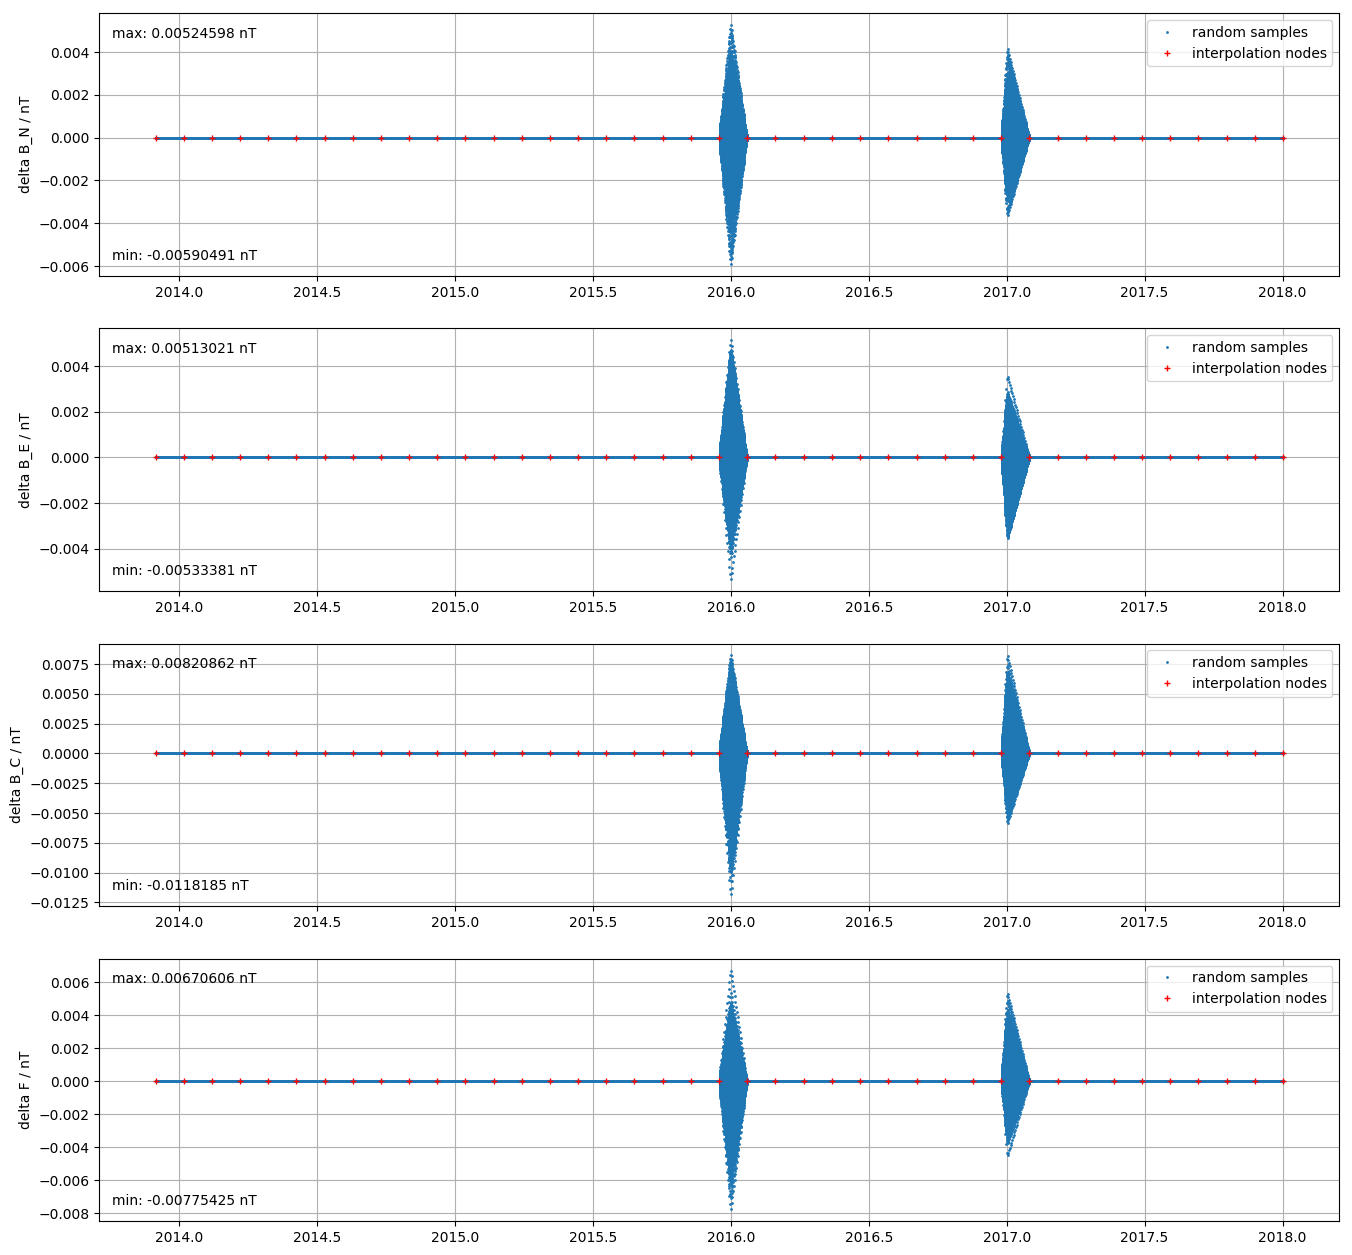

In [9]:
model = load_model_shc(MODEL_FILE)
node_times = mjd2000_to_decimal_year(model.coefficients._times)
node_val = zeros(node_times.shape)

delta_b_nec = b_nec_dy - b_nec_mjd2k
delta_f = vnorm(b_nec_dy) - vnorm(b_nec_mjd2k)

fig = plt.figure(figsize=(16, 16), dpi=100)
plt.title("decimal year vs. MJD2000 time domain")

times_dy = mjd2000_to_decimal_year(times)
    
ax = plt.subplot(4, 1, 1)
plot(ax, times_dy, delta_b_nec[..., 0], "delta B_N / nT")

ax = plt.subplot(4, 1, 2)
plot(ax, times_dy, delta_b_nec[..., 1], "delta B_E / nT")

ax = plt.subplot(4, 1, 3)
plot(ax, times_dy, delta_b_nec[..., 2], "delta B_C / nT")

ax = plt.subplot(4, 1, 4)
plot(ax, times_dy, delta_f, "delta F / nT")

plt.show()
%matplotlib inline

### Effect of the regular vs. simplified decimal year calculation

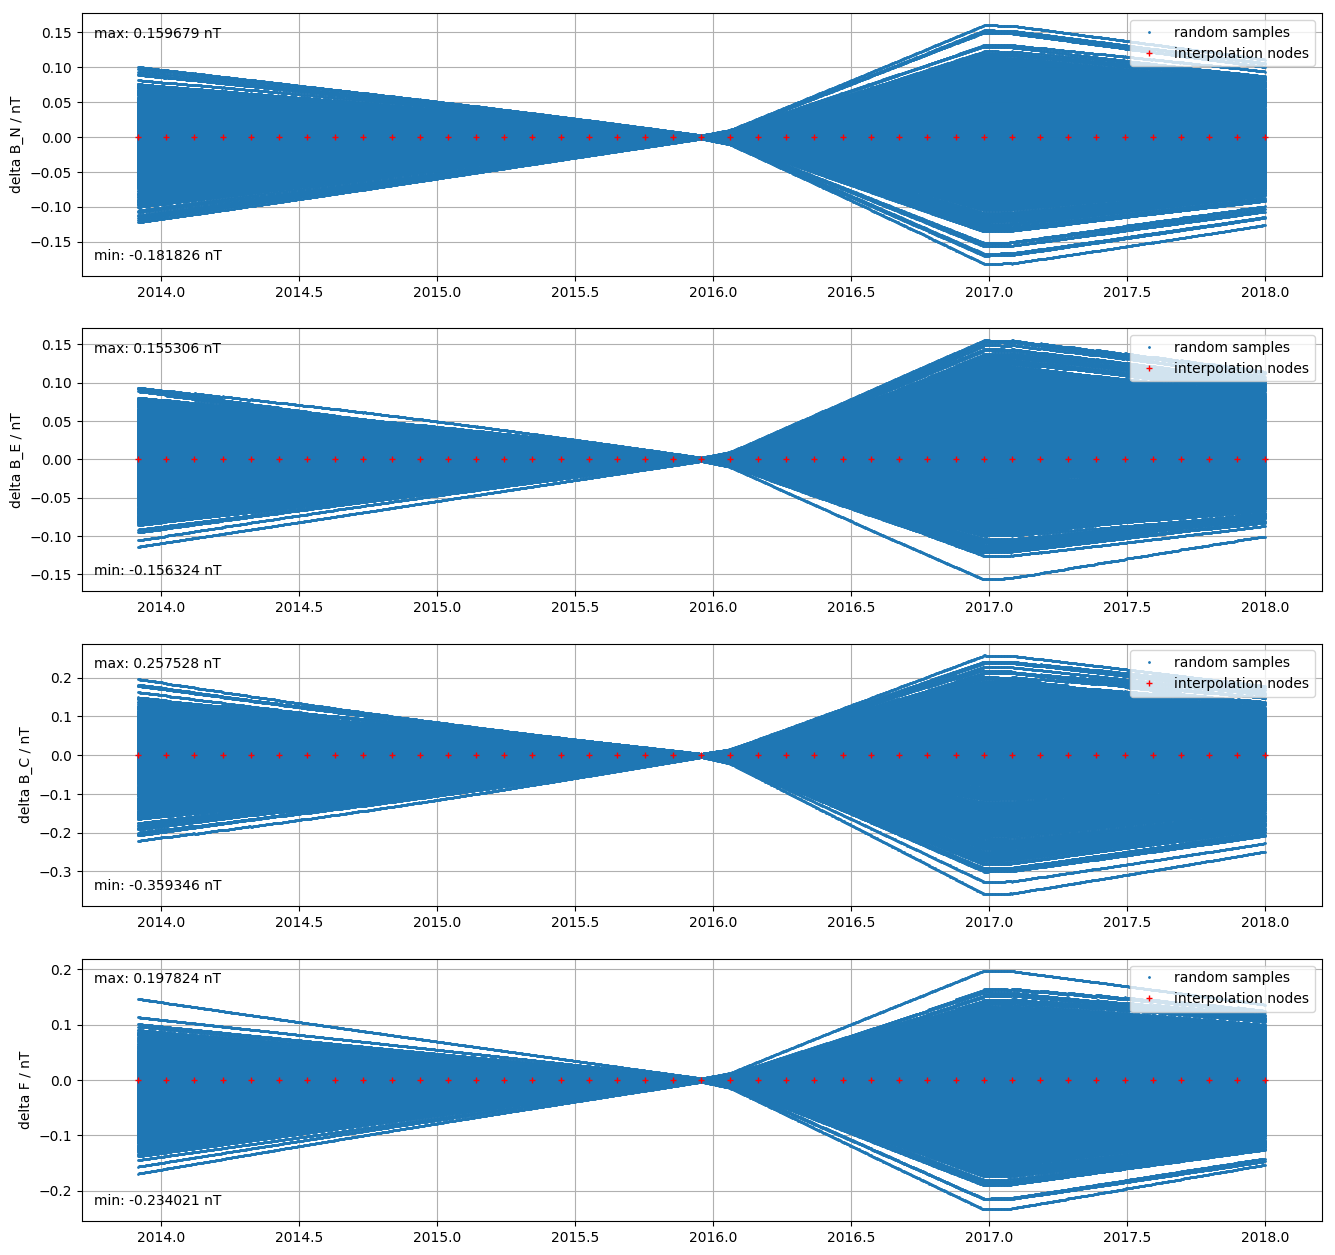

In [10]:
model = load_model_shc(MODEL_FILE)
node_times = mjd2000_to_decimal_year(model.coefficients._times)
node_val = zeros(node_times.shape)

delta_b_nec = b_nec_mjd2k_simple - b_nec_mjd2k
delta_f = vnorm(b_nec_mjd2k_simple) - vnorm(b_nec_mjd2k)

fig = plt.figure(figsize=(16, 16), dpi=100)
plt.title("decimal year vs. MJD2000 time domain")

times_dy = mjd2000_to_decimal_year(times)

ax = plt.subplot(4, 1, 1)
plot(ax, times_dy, delta_b_nec[..., 0], "delta B_N / nT")

ax = plt.subplot(4, 1, 2)
plot(ax, times_dy, delta_b_nec[..., 1], "delta B_E / nT")

ax = plt.subplot(4, 1, 3)
plot(ax, times_dy, delta_b_nec[..., 2], "delta B_C / nT")

ax = plt.subplot(4, 1, 4)
plot(ax, times_dy, delta_f, "delta F / nT")

plt.show()
%matplotlib inline

### Plot the random locations

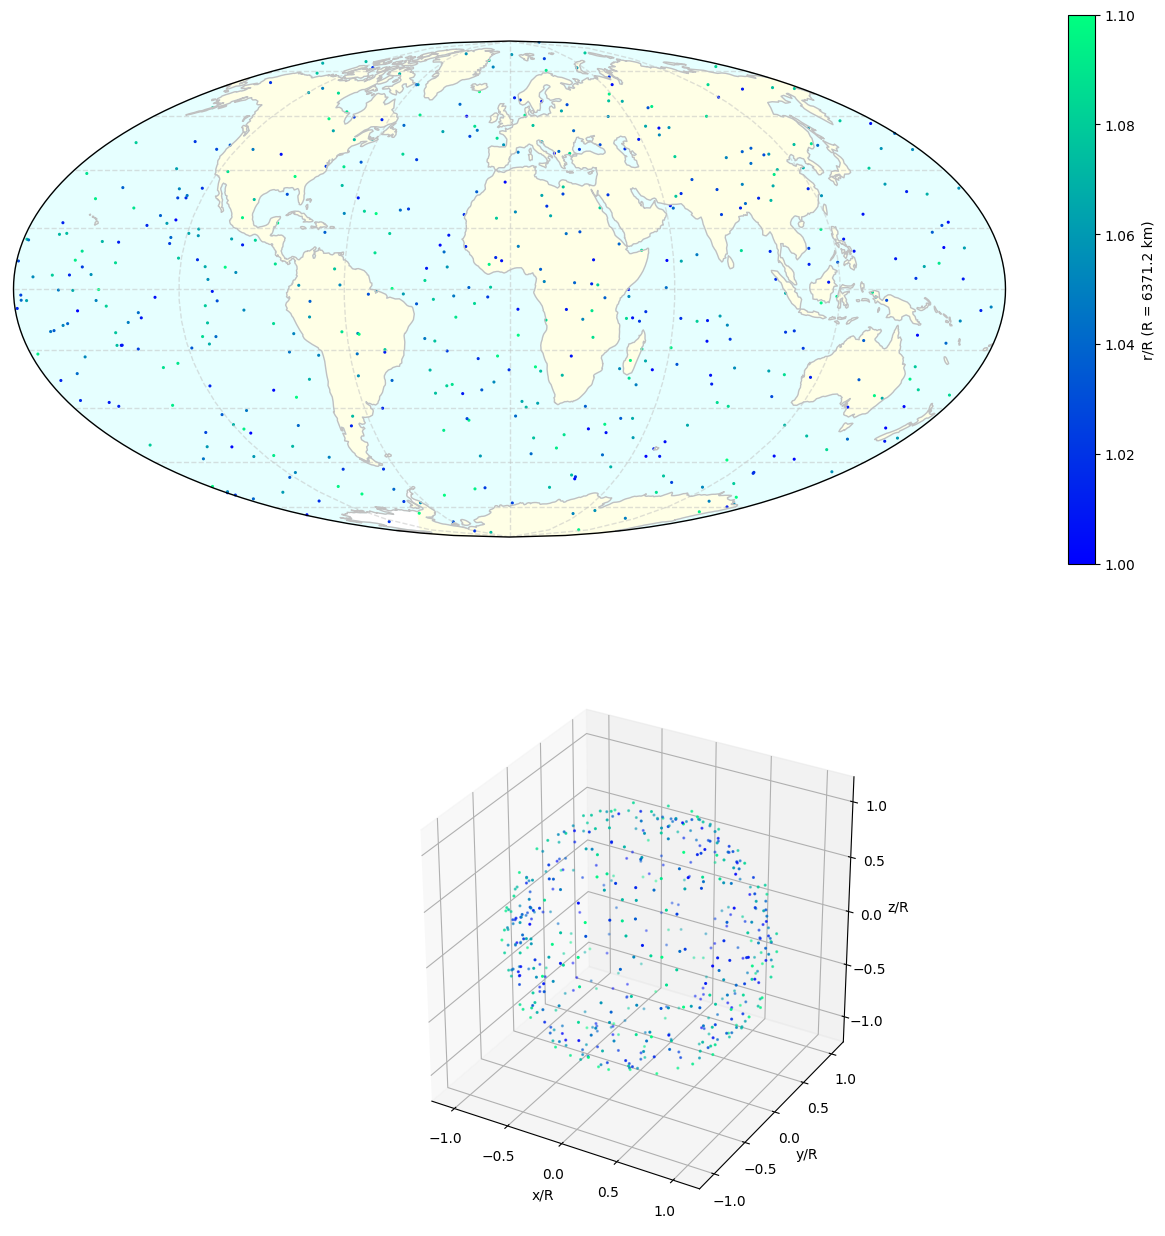

In [11]:
from cartopy.feature import LAND, OCEAN, COASTLINE
from cartopy.crs import Mollweide, PlateCarree
from matplotlib import pyplot as plt
from matplotlib.cm import winter as colormap
from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase
from mpl_toolkits.mplot3d import Axes3D
from eoxmagmod import convert, GEOCENTRIC_SPHERICAL, GEOCENTRIC_CARTESIAN
%matplotlib inline

norm = Normalize(vmin=1,vmax=1.1)

#help(ccrs)
fig = plt.figure(figsize=(16, 16), dpi=100, facecolor='w', edgecolor='k')
ax = plt.subplot(2, 1, 1, projection=Mollweide())
gl = ax.gridlines(crs=PlateCarree(), draw_labels=False, linewidth=1, color='silver', alpha=0.5, linestyle='--')
ax.add_feature(LAND, facecolor=(1.0, 1.0, 0.9))
ax.add_feature(OCEAN, facecolor=(0.9, 1.0, 1.0))
ax.add_feature(COASTLINE, edgecolor='silver')


obj = ax.scatter(
    lons, lats, c=rads/EARTH_RADIUS, s=1.5,
    cmap=colormap, norm=norm, transform=PlateCarree(),
     
)
cb = plt.colorbar(obj)
cb.ax.set_ylabel("r/R (R = %g km)" % EARTH_RADIUS)


ax = plt.subplot(2, 1, 2, projection='3d')

cart_coords = convert(coords, GEOCENTRIC_SPHERICAL, GEOCENTRIC_CARTESIAN)/EARTH_RADIUS
obj = ax.scatter(
    cart_coords[:, 0], cart_coords[:, 1], cart_coords[:, 2], 
    c=rads/EARTH_RADIUS, s=1.5,
    cmap=colormap, norm=norm,
)

ax.set_aspect('equal','box')
ax.set_xlabel("x/R")
ax.set_ylabel("y/R")
ax.set_zlabel("z/R")

plt.show()